# Boston Celtics Specific Model

In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Importing 4 Seasons of NBA Data (2020-2024)

In [3]:
season_20 = pd.read_csv('../data_generation/output_data/2020-21_data.csv')
season_21 = pd.read_csv('../data_generation/output_data/2021-22_data.csv')
season_22 = pd.read_csv('../data_generation/output_data/2022-23_data.csv')
season_23 = pd.read_csv('../data_generation/output_data/2023-24_data.csv')

combined_seasons = pd.concat([season_20, season_21, season_22, season_23], ignore_index=True)
combined_season = combined_seasons.drop_duplicates()
combined_seasons = combined_seasons.reset_index(drop=True)

# combined_seasons.head(10)

## Mapping Team ID to City

In [4]:
TEAM_CITY_MAPPING = {
    1610612737: "Atlanta, GA",
    1610612738: "Boston, MA",
    1610612739: "Cleveland, OH",
    1610612740: "New Orleans, LA",
    1610612741: "Chicago, IL",
    1610612742: "Dallas, TX",
    1610612743: "Denver, CO",
    1610612744: "San Francisco, CA",
    1610612745: "Houston, TX",
    1610612746: "Los Angeles, CA (Lakers)",
    1610612747: "Los Angeles, CA (Clippers)",
    1610612748: "Miami, FL",
    1610612749: "Milwaukee, WI",
    1610612750: "Minneapolis, MN",
    1610612751: "Brooklyn, NY",
    1610612752: "New York, NY",
    1610612753: "Orlando, FL",
    1610612754: "Indianapolis, IN",
    1610612755: "Philadelphia, PA",
    1610612756: "Phoenix, AZ",
    1610612757: "Portland, OR",
    1610612758: "Sacramento, CA",
    1610612759: "San Antonio, TX",
    1610612760: "Oklahoma City, OK",
    1610612761: "Toronto, ON (Canada)",
    1610612762: "Salt Lake City, Utah",
    1610612763: "Memphis, TN",
    1610612764: "Washington, D.C.",
    1610612765: "Detroit, MI",
    1610612766: "Charlotte, NC"
}

boston_celtics = 1610612738
boston_data = combined_seasons.loc[combined_seasons["teamId"] == boston_celtics]

# boston_data.head(10)


## Prepare features and target value for the Boston Celtics

In [5]:
input = boston_data.drop(columns=['PTS'])
target = boston_data['PTS']

spearman_corr = pd.read_csv('../data_generation/output_data/spearman_corr_features.csv')

selected_features = spearman_corr['Feature'].tolist()

existing_features = [feature for feature in selected_features if feature in input.columns]

input = boston_data[existing_features]
input = input.dropna(axis=1)
print(input.info()) # 318 entries, 126 columns

# Split data est
input_train, input_test, target_train, target_test = train_test_split(input, target, test_size=0.2, random_state=0)

# Scaling features
scaler = StandardScaler()
input_train = scaler.fit_transform(input_train)
input_test = scaler.transform(input_test)

<class 'pandas.core.frame.DataFrame'>
Index: 318 entries, 20 to 9526
Columns: 126 entries, fieldGoalPercentage_my_player_1 to OPPONENT_WIN_PCT
dtypes: float64(123), int64(3)
memory usage: 315.5 KB
None


## Define the Model

In [6]:
# Initialize sequential model 
model = Sequential([
    Input(shape=(input_train.shape[1],)), # define input shape
    Dense(64, activation='relu'), # first hidden layer with 64 units
    Dropout(0.2),
    Dense(32, activation='relu'), # second hidden layer with 32 units
    Dense(1) # OUtput with target (PTS)
])

# Compile the model 
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(input_train, target_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - loss: 13588.4033 - mae: 115.8235 - val_loss: 13726.5439 - val_mae: 116.5138
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 13209.2178 - mae: 114.1821 - val_loss: 13560.9844 - val_mae: 115.8005
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 13035.7490 - mae: 113.4837 - val_loss: 13397.0801 - val_mae: 115.0908
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 12829.5371 - mae: 112.4307 - val_loss: 13222.4219 - val_mae: 114.3300
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 12921.8242 - mae: 112.8528 - val_loss: 13023.5635 - val_mae: 113.4600
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 12363.0684 - mae: 110.3957 - val_loss: 12786.7070 - val_mae: 112.4134
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 12098.6094 - mae: 109.1612 - val_loss: 12499.5918 - val_mae: 111.1330
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 11975.1797 - mae: 108.5491 - val_loss: 12151.3721 - va

## Visualize History

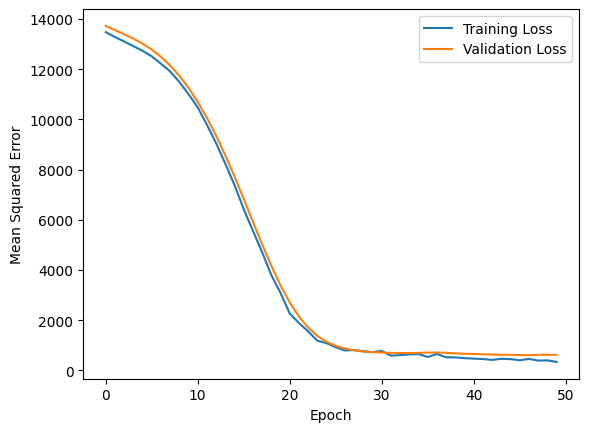

In [7]:
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

## Evaluation and Sample Target Prediction

In [16]:
# Evaluate model and test data
test_loss, test_mae = model.evaluate(input_test, target_test)

# Target prediction
sample_predictions = model.predict(input_test)

mse = mean_squared_error(target_test, sample_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(target_test, sample_predictions)

print("\n--- Regression Metrics ---")
print(f"Test Loss (MSE from model): {test_loss:.2f}")
print(f"Test MAE (from model): {test_mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-Squared (R²): {r2:.2f}")

print("Sample Prediction (PTS):", sample_predictions[:10].flatten())
print("Actual Values (PTS):", target_test[:10].values)

bos_results = pd.DataFrame({
    "Actual PTS": target_test,
    "Predicted PTS": sample_predictions.flatten()
})

bos_results.to_csv("boston_celtics_model_eval.csv", index=False)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 824.7609 - mae: 23.1029
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

--- Regression Metrics ---
Test Loss (MSE from model): 901.04
Test MAE (from model): 24.42
Mean Squared Error (MSE): 901.04
Root Mean Squared Error (RMSE): 30.02
R-Squared (R²): -3.63
Sample Prediction (PTS): [104.596954 116.79762   69.05172  122.100685  90.189354  83.571
 134.798    119.79313  109.24045   94.96094 ]
Actual Values (PTS): [119 133 119 132 142 143 119 123 117 106]


## Evaluate the General NN Model Performance

In [18]:
gen_model = load_model("general_nn_score_predictor.keras")
# print("Model loaded successfully.")

# Evaluate model and test data

test_loss, test_mae = gen_model.evaluate(input_test, target_test)

# Target prediction
gen_predictions = gen_model.predict(input_test)

mse = mean_squared_error(target_test, gen_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(target_test, gen_predictions)

print("Sample Prediction (PTS):", gen_predictions[:10].flatten())
print("Actual Values (PTS):", target_test[:10].values)

print("\n--- Regression Metrics ---")
print(f"Test Loss (MSE from model): {test_loss:.2f}")
print(f"Test MAE (from model): {test_mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-Squared (R²): {r2:.2f}")

gen_results = pd.DataFrame({
    "Actual PTS": target_test,
    "Predicted PTS": gen_predictions.flatten()
})
gen_results.to_csv("gen_model_boston_celtics_eval.csv", index=False)

C:\Users\ayu92\Documents\cs6140_project\venv\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 111.6514 - mae: 8.5402
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step 
Sample Prediction (PTS): [106.30503  124.99361  116.24621  119.324036 125.97657  127.821754
 110.61551  115.48204  107.54977  114.183266]
Actual Values (PTS): [119 133 119 132 142 143 119 123 117 106]

--- Regression Metrics ---
Test Loss (MSE from model): 113.17
Test MAE (from model): 8.52
Mean Squared Error (MSE): 113.17
Root Mean Squared Error (RMSE): 10.64
R-Squared (R²): 0.42


In [9]:
# Save the trained model to a file
# model.save("bos_specific_nn.keras")
# print("Model saved as 'bos_specific.keras'")

Model saved as 'bos_specific.keras'
